## 1.0 Importação e EDA

In [22]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet,                                 SGDRegressor, PassiveAggressiveRegressor)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import warnings
import matplotlib.dates as mdates


#Suprimindo os warnings

warnings.filterwarnings("ignore", message="DataFrame is highly fragmented.*")
warnings.filterwarnings("ignore", message=".*Ill-conditioned matrix.*")
warnings.filterwarnings("ignore", message=".*Objective did not converge.*")


In [16]:
df = pd.read_csv(r'financial_regression.csv')

### 1.1 Analisando Correlações

In [17]:
df_clean = df.drop(columns=['date']).dropna()


correlacoes = df_clean.corr(numeric_only=True)['gold close'].sort_values(ascending=False)


correlacoes_relevantes = correlacoes[abs(correlacoes) >= 0.3]


correlacoes_relevantes.head(15)

gold close       1.000000
gold low         0.999794
gold high        0.999624
gold open        0.999273
silver volume    0.811787
nasdaq high      0.752980
nasdaq close     0.752352
nasdaq low       0.752277
nasdaq open      0.752061
CPI              0.728289
sp500 high       0.701180
sp500 low        0.699721
sp500 open       0.699705
sp500 close      0.699622
GDP              0.680805
Name: gold close, dtype: float64

### 1.2 Criando as primeiras features  

In [19]:
#Criando features de janela que são compostas por: Valor, média e desvio padrão  nas janelas específicas 

df_clean = df.drop(columns=['date']).dropna()

correlacoes = df_clean.corr(numeric_only=True)['gold close'].sort_values(ascending=False)
correlacoes_relevantes = correlacoes[abs(correlacoes) >= 0.3].drop('gold close').head(15).to_dict()

windows = [7, 15, 30]

for col in correlacoes_relevantes.keys():
    for w in windows:
        df[f"{col}_lag_{w}"] = df[col].shift(w)
        df[f"{col}_roll_mean_{w}"] = df[col].rolling(window=w).mean()
        df[f"{col}_roll_std_{w}"] = df[col].rolling(window=w).std()

new_cols = [f"{col}_{tipo}_{w}" for col in correlacoes_relevantes.keys() for w in windows for tipo in ["lag", "roll_mean", "roll_std"]]
print(f"Colunas criadas : {new_cols}")


Colunas criadas : ['gold low_lag_7', 'gold low_roll_mean_7', 'gold low_roll_std_7', 'gold low_lag_15', 'gold low_roll_mean_15', 'gold low_roll_std_15', 'gold low_lag_30', 'gold low_roll_mean_30', 'gold low_roll_std_30', 'gold high_lag_7', 'gold high_roll_mean_7', 'gold high_roll_std_7', 'gold high_lag_15', 'gold high_roll_mean_15', 'gold high_roll_std_15', 'gold high_lag_30', 'gold high_roll_mean_30', 'gold high_roll_std_30', 'gold open_lag_7', 'gold open_roll_mean_7', 'gold open_roll_std_7', 'gold open_lag_15', 'gold open_roll_mean_15', 'gold open_roll_std_15', 'gold open_lag_30', 'gold open_roll_mean_30', 'gold open_roll_std_30', 'silver volume_lag_7', 'silver volume_roll_mean_7', 'silver volume_roll_std_7', 'silver volume_lag_15', 'silver volume_roll_mean_15', 'silver volume_roll_std_15', 'silver volume_lag_30', 'silver volume_roll_mean_30', 'silver volume_roll_std_30', 'nasdaq high_lag_7', 'nasdaq high_roll_mean_7', 'nasdaq high_roll_std_7', 'nasdaq high_lag_15', 'nasdaq high_roll_

### 1.3 Analisando correlações das novas features e das já existentes

In [20]:
novas_correlacoes = df.corr(numeric_only=True)['gold close'].sort_values(ascending=False)

novas_correlacoes = novas_correlacoes[abs(novas_correlacoes) >= 0.3]




gold low                      0.999764
gold high                     0.999743
gold open                     0.999463
gold low_roll_mean_7          0.997512
gold high_roll_mean_7         0.997365
gold open_roll_mean_7         0.997189
gold low_roll_mean_15         0.994846
gold high_roll_mean_15        0.994810
gold open_roll_mean_15        0.994647
gold high_roll_mean_30        0.992164
gold open_roll_mean_30        0.991837
gold low_roll_mean_30         0.991743
gold high_lag_7               0.991726
gold low_lag_7                0.991708
gold open_lag_7               0.991508
gold high_lag_15              0.983292
gold low_lag_15               0.983264
gold open_lag_15              0.983023
gold low_lag_30               0.968130
gold high_lag_30              0.967958
gold open_lag_30              0.967776
silver volume_roll_mean_30    0.816628
oil close_roll_mean_30        0.768349
silver volume_roll_mean_15    0.766830
oil close_roll_mean_15        0.759204
oil close_roll_mean_7    

## 2.0 Criação Do Modelo

### 2.1 Análise de diferentes tipos de modelos de Regressão e pré-processamento

In [24]:


sem_random = 3141592


model_dict = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=sem_random),
    'Lasso': Lasso(random_state=sem_random),
    'ElasticNet': ElasticNet(random_state=sem_random),
    'SGDRegressor': SGDRegressor(random_state=sem_random),
    'PassiveAggressiveRegressor': PassiveAggressiveRegressor(random_state=sem_random),
    'RandomForest': RandomForestRegressor(random_state=sem_random),
    'GradientBoosting': GradientBoostingRegressor(random_state=sem_random)
}

imputer = SimpleImputer(missing_values=np.nan, strategy="constant")
cols_to_impute = df.columns[~df.columns.isin(['date', 'gold close'])]
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])
df = df[df['gold close'].notna()]

dict_models_predict = {}

for name, model in model_dict.items():
    target = 'gold close'
    features = [col for col in df.columns if col not in ['date', target]]
    
    train, test = train_test_split(df, test_size=0.2, shuffle=False)
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    dict_models_predict[name] = y_pred
   
    print(f"\nModelo: {name}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    



Modelo: LinearRegression
MAE: 0.32
R²: 0.9997

Modelo: Ridge
MAE: 0.31
R²: 0.9997

Modelo: Lasso
MAE: 0.57
R²: 0.9988

Modelo: ElasticNet
MAE: 0.52
R²: 0.9991

Modelo: SGDRegressor
MAE: 9602795561483511986651136.00
R²: -207206118380005410059557521835306625367487283200.0000

Modelo: PassiveAggressiveRegressor
MAE: 47.39
R²: -5.6947

Modelo: RandomForest
MAE: 7.69
R²: 0.4450

Modelo: GradientBoosting
MAE: 7.01
R²: 0.5305


<class 'pandas.core.frame.DataFrame'>
Index: 2975 entries, 0 to 3121
Columns: 180 entries, sp500 open to oil close_roll_std_30
dtypes: float64(180)
memory usage: 4.1 MB


### 2.2 Validação Cruzada 

In [25]:

cv = TimeSeriesSplit(n_splits=5)

imputer = SimpleImputer(missing_values=np.nan, strategy="constant")
cols_to_impute = df.columns[~df.columns.isin(['date', 'gold close'])]
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])
df = df[df['gold close'].notna()]


for name, model in model_dict.items():
    target = 'gold close'
    features = [col for col in df.columns if col not in ['date', target]]
    
    imputer = SimpleImputer(missing_values=np.nan, strategy="constant")
    cols_to_impute = df.columns[~df.columns.isin(['date', 'gold close'])]
    X = df[features]
    y = df[target]

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
 
    r2_scores = cross_val_score(pipe, X, y, cv=cv, scoring='r2')

    mae_scores = -cross_val_score(pipe, X, y, cv=cv, scoring='neg_mean_absolute_error')
    print(f"\nModelo: {name}")
    print(f" Média do R²: {r2_scores.mean():.4f} (± {r2_scores.std():.4f})")
    print(f" Média do MAE: {mae_scores.mean():.2f} (± {mae_scores.std():.2f})")



Modelo: LinearRegression
 Média do R²: 0.9973 (± 0.0020)
 Média do MAE: 0.35 (± 0.08)

Modelo: Ridge
 Média do R²: 0.9979 (± 0.0010)
 Média do MAE: 0.39 (± 0.12)

Modelo: Lasso
 Média do R²: 0.9808 (± 0.0156)
 Média do MAE: 1.40 (± 0.69)

Modelo: ElasticNet
 Média do R²: 0.3854 (± 0.1892)
 Média do MAE: 8.98 (± 3.70)

Modelo: SGDRegressor
 Média do R²: 0.9917 (± 0.0037)
 Média do MAE: 0.82 (± 0.37)

Modelo: PassiveAggressiveRegressor
 Média do R²: 0.9854 (± 0.0122)
 Média do MAE: 0.89 (± 0.40)

Modelo: RandomForest
 Média do R²: 0.8722 (± 0.2230)
 Média do MAE: 2.34 (± 3.34)

Modelo: GradientBoosting
 Média do R²: 0.8855 (± 0.2054)
 Média do MAE: 2.24 (± 3.17)


### 2.3 Coleta das previsões dos modelos treinados

In [28]:
predictions_df = pd.DataFrame(dict_models_predict)
predictions_df.index = test.index
test_with_predictions = pd.concat([test.reset_index(drop=True), predictions_df.reset_index(drop=True)], axis=1)


### 2.4 Resultado do Modelo final

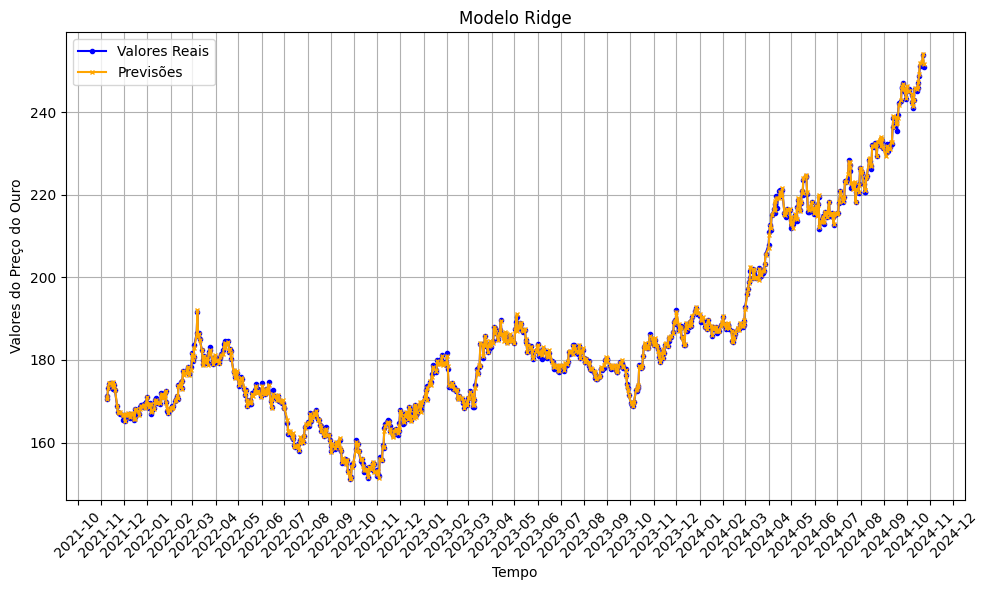

In [35]:
test_with_predictions['date'] = pd.to_datetime(test_with_predictions['date'], errors='coerce')
plt.figure(figsize=(10, 6))
plt.plot(test_with_predictions['date'], test_with_predictions['gold close'], label='Valores Reais', color='blue', marker='o', markersize=3)
plt.plot(test_with_predictions['date'], test_with_predictions['Ridge'], label='Previsões', color='orange', marker='x', markersize=3)
plt.title('Modelo Ridge')
plt.xlabel('Tempo')
plt.ylabel('Valores do Preço do Ouro')
plt.legend()
plt.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()